In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

from joblib import dump

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler#, StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

Definindo o tema do seaborn:

In [2]:
sns.set_theme()

Definição da SEED:

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED) # Numpy

# Carregando os dados

Os valores são números muito pequenos com muitas casas decimais, por isso é bom que o dataframe consiga representar isso também.

In [4]:
pd.set_option('display.float_format', '{:.20f}'.format)

Carregando os dados:

In [5]:
df_benign = pd.read_csv("data/dados benignos/mensagens_benignas.csv")
df_benign

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,3,193,0,0,0,-1
1,0.00012946128845210000,3,193,0,0,0,-1
2,0.00015544891357419999,3,193,0,0,0,-1
3,0.00015616416931149999,3,193,0,0,0,-1
4,0.00013208389282220000,2,194,24,0,-1,-1
...,...,...,...,...,...,...,...
2673812,0.00172662734985350001,1,165,88,-1,-1,-1
2673813,0.00108718872070310006,1,165,88,-1,-1,-1
2673814,0.00091290473937979998,1,165,88,-1,-1,-1
2673815,0.00008821487426757812,1,165,88,-1,-1,-1


In [6]:
df_malicious_random_dos = pd.read_csv("data/ataques/mensagens_maliciosas_random_dos.csv")
df_malicious_spoofing_zero_payload = pd.read_csv("data/ataques/mensagens_maliciosas_spoofing_zero_payload.csv")
df_malicious_zero_dos = pd.read_csv("data/ataques/mensagens_maliciosas_zero_dos.csv")

In [7]:
df_malicious_random_dos

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,192,17,110,1,93
1,0.00037145614624020001,1,1061,225,-1,-1,-1
2,0.00169730186462400002,2,1412,198,237,-1,-1
3,0.00179910659790029999,1,2035,254,-1,-1,-1
4,0.00183224678039550001,3,544,66,102,79,-1
...,...,...,...,...,...,...,...
455997,0.00016474723815910000,4,192,207,106,1,92
455998,0.00016379356384270001,4,192,207,106,1,92
455999,0.00016403198242180000,4,192,207,106,1,92
456000,0.00016498565673819999,4,192,207,106,1,92


In [8]:
df_malicious_spoofing_zero_payload

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,0,0,0,0,0
1,0.00161838531494139996,4,0,0,0,0,0
2,0.00169730186462400002,4,0,0,0,0,0
3,0.00061082839965819998,4,192,0,0,0,0
4,0.00175023078918450006,4,0,0,0,0,0
...,...,...,...,...,...,...,...
568457,0.00015544891357419999,3,193,0,0,0,-1
568458,0.00015711784362790001,3,193,0,0,0,-1
568459,0.00015830993652339999,3,193,0,0,0,-1
568460,0.00012922286987300001,2,194,0,0,-1,-1


In [9]:
df_malicious_zero_dos

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,0,0,0,0,0
1,0.00115513801574700006,4,0,0,0,0,0
2,0.00147318840026850004,4,0,0,0,0,0
3,0.00123977661132810006,4,0,0,0,0,0
4,0.00169897079467769990,4,0,0,0,0,0
...,...,...,...,...,...,...,...
741977,0.00014257431030270001,2,194,236,255,-1,-1
741978,0.00012278556823730000,2,194,236,255,-1,-1
741979,0.00013160705566400000,2,194,236,255,-1,-1
741980,0.00016975402832030000,4,192,147,117,1,95


Manipualação da quantidade/proporção dos dados:

In [10]:
# OPCIONAL!!!
len_min = min(len(df_benign),len(df_malicious_random_dos),len(df_malicious_spoofing_zero_payload),len(df_malicious_zero_dos))
NUM_OF_ATTACKS = 3

len_min = int(len_min / 80)

df_benign = df_benign.head(len_min * NUM_OF_ATTACKS)
df_malicious_random_dos = df_malicious_random_dos.head(len_min)
df_malicious_spoofing_zero_payload = df_malicious_spoofing_zero_payload.head(len_min)
df_malicious_zero_dos = df_malicious_zero_dos.head(len_min)

In [11]:
del len_min

# Tratando dados

## Normalização dos dados

Criação e uso do scaler:

In [12]:
scaler = MinMaxScaler()

scaler.fit(df_benign)

df_benign_scaled = pd.DataFrame(scaler.transform(df_benign), columns=df_benign.columns, index=df_benign.index)
df_malicious_random_dos_scaled = pd.DataFrame(scaler.transform(df_malicious_random_dos), columns=df_malicious_random_dos.columns, index=df_malicious_random_dos.index)
df_malicious_spoofing_zero_payload_scaled = pd.DataFrame(scaler.transform(df_malicious_spoofing_zero_payload), columns=df_malicious_spoofing_zero_payload.columns, index=df_malicious_spoofing_zero_payload.index)
df_malicious_zero_dos_scaled = pd.DataFrame(scaler.transform(df_malicious_zero_dos), columns=df_malicious_zero_dos.columns, index=df_malicious_zero_dos.index)

In [13]:
del df_benign
del df_malicious_random_dos
del df_malicious_spoofing_zero_payload
del df_malicious_zero_dos

In [14]:
df_benign_scaled

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,0.66666666666666674068,0.97058823529411775155,0.00000000000000000000,0.00740740740740740769,0.25000000000000000000,0.00000000000000000000
1,0.00199053487834934852,0.66666666666666674068,0.97058823529411775155,0.00000000000000000000,0.00740740740740740769,0.25000000000000000000,0.00000000000000000000
2,0.00239010817805544078,0.66666666666666674068,0.97058823529411775155,0.00000000000000000000,0.00740740740740740769,0.25000000000000000000,0.00000000000000000000
3,0.00240110560832249628,0.66666666666666674068,0.97058823529411775155,0.00000000000000000000,0.00740740740740740769,0.25000000000000000000,0.00000000000000000000
4,0.00203085878932855214,0.33333333333333331483,1.00000000000000000000,0.09917355371900826722,0.00740740740740740769,0.00000000000000000000,0.00000000000000000000
...,...,...,...,...,...,...,...
17095,0.00177425208309571914,0.00000000000000000000,0.14705882352941124225,0.09504132231404958941,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
17096,0.00199053487834934852,0.33333333333333331483,1.00000000000000000000,0.14876033057851240082,0.00740740740740740769,0.00000000000000000000,0.00000000000000000000
17097,0.00202719297923953379,0.33333333333333331483,1.00000000000000000000,0.14876033057851240082,0.00740740740740740769,0.00000000000000000000,0.00000000000000000000
17098,0.00255873544215029242,1.00000000000000000000,0.94117647058823461492,0.57438016528925617266,1.00000000000000000000,0.50000000000000000000,0.99009900990099009022


## Criação de Labels

In [15]:
list_labels_benign = [1] * len(df_benign_scaled)
list_labels_random_dos = [-1] * len(df_malicious_random_dos_scaled)
list_labels_spoofing_zero_payload = [-1] * len(df_malicious_spoofing_zero_payload_scaled)
list_labels_zero_dos = [-1] * len(df_malicious_zero_dos_scaled)

classifier_type = "bc"

## Criação de Janelas Temporais

### Criação de Janelas Deslizantes

Criação da função de divisão dos dados em janelas:

In [16]:
def create_slicing_windows(data, labels, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(labels[i + time_step])
    return np.array(X), np.array(Y)

Definição do tamanho da janela:

In [17]:
WINDOW_SIZE = 150

Criação das janelas deslizantes:

In [18]:
benign_windows, benign_labels = create_slicing_windows(df_benign_scaled, list_labels_benign, WINDOW_SIZE)
del df_benign_scaled, list_labels_benign

malicious_random_dos_windows, malicious_random_dos_labels = create_slicing_windows(df_malicious_random_dos_scaled, list_labels_random_dos, WINDOW_SIZE)
del df_malicious_random_dos_scaled, list_labels_random_dos

malicious_spoofing_zero_payload_windows, malicious_spoofing_zero_payload_labels = create_slicing_windows(df_malicious_spoofing_zero_payload_scaled, list_labels_spoofing_zero_payload, WINDOW_SIZE)
del df_malicious_spoofing_zero_payload_scaled, list_labels_spoofing_zero_payload

malicious_zero_dos_windows, malicious_zero_dos_labels = create_slicing_windows(df_malicious_zero_dos_scaled, list_labels_zero_dos, WINDOW_SIZE)
del df_malicious_zero_dos_scaled, list_labels_zero_dos

In [19]:
len(benign_windows), len(benign_windows[0])

(16950, 150)

In [20]:
benign_windows

array([[[0.        , 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.00199053, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.00239011, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        ...,
        [0.00236811, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.00239377, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.00204919, 0.33333333, 1.        , ..., 0.00740741,
         0.        , 0.        ]],

       [[0.00199053, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.00239011, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.00240111, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        ...,
        [0.00239377, 0.66666667, 0.97058824, ..., 0.00740741,
         0.25      , 0.        ],
        [0.0

## Dividindo dados em Treino, Validação e Teste

Quantidade de dados benignos dividido pelo total:

In [21]:
len(benign_windows) / (len(benign_windows) + len(malicious_random_dos_windows) + len(malicious_spoofing_zero_payload_windows) + len(malicious_zero_dos_windows))

0.5044642857142857

Concatenação das janelas, em ordem:

In [22]:
data = np.vstack((benign_windows, malicious_random_dos_windows, malicious_spoofing_zero_payload_windows, malicious_zero_dos_windows))

In [23]:
data_malicious = np.vstack((malicious_random_dos_windows, malicious_spoofing_zero_payload_windows, malicious_zero_dos_windows))

In [24]:
data_labels = np.hstack((benign_labels, malicious_random_dos_labels, malicious_spoofing_zero_payload_labels, malicious_zero_dos_labels))

In [25]:
data_malicious_labels = np.hstack((malicious_random_dos_labels, malicious_spoofing_zero_payload_labels, malicious_zero_dos_labels))

In [26]:
del malicious_random_dos_windows
del malicious_spoofing_zero_payload_windows
del malicious_zero_dos_windows

del benign_labels
del malicious_random_dos_labels
del malicious_spoofing_zero_payload_labels
del malicious_zero_dos_labels

### Divisão em treino, validação e teste.

Abordagem supervisionada:

In [27]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data, data_labels, test_size=0.25, random_state=RANDOM_SEED)

In [28]:
val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, test_size=0.5, random_state=RANDOM_SEED)

In [29]:
del data, data_labels
del val_test_data, val_test_labels

Abordagem não-supervisionada:

In [30]:
train_data_2 = benign_windows[:(len(benign_windows) // 2)]

test_data_2 = np.vstack((data_malicious, benign_windows[(len(benign_windows) // 2):]))

malicious_proportion = len(data_malicious) / (len(data_malicious) + len(benign_windows[(len(benign_windows) // 2):]))

In [31]:
#benign_labels = [1] * (len(benign_windows) // 2)

#test_data_2_labels = np.hstack(( data_malicious_labels, benign_labels))

In [32]:
del data_malicious
del benign_windows
del benign_labels

Shape dos dados de treino:

In [33]:
train_data.shape

(25200, 150, 7)

# IAs

## LSTM (supervisionado)

Variável que define se é supervisionado ou não-supervisionado:

In [34]:
s_OR_ns = "s"

Quantidade de features, para o modelo lidar com as entradas:

In [35]:
FEATURES_COUNT = train_data.shape[2] # Número de features dos dados

Construção do modelo LSTM:

In [36]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES_COUNT)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, kernel_regularizer=l2(0.0000001)))

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')
#model.compile(optimizer="adam", loss='mse')

Definição da paciência:

In [37]:
PATIENCE = 4

Configuração do early stop:

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

Definição da quantidade de épocas e da quantidade de batchs:

In [39]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

**TREINAMENTO DO MODELO:**

In [40]:
# Treinando o modelo
history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels), callbacks=[early_stopping])

Epoch 1/50
788/788 [==============================] - 19s 23ms/step - loss: 0.1014 - val_loss: 0.0091
Epoch 2/50
788/788 [==============================] - 18s 22ms/step - loss: 0.0396 - val_loss: 0.0041
Epoch 3/50
788/788 [==============================] - 18s 22ms/step - loss: 0.0356 - val_loss: 0.0025
Epoch 4/50
788/788 [==============================] - 18s 22ms/step - loss: 0.0499 - val_loss: 0.0027
Epoch 5/50
788/788 [==============================] - 18s 23ms/step - loss: 0.0361 - val_loss: 0.0019
Epoch 6/50
788/788 [==============================] - 19s 24ms/step - loss: 0.0354 - val_loss: 0.0017
Epoch 7/50
788/788 [==============================] - 19s 24ms/step - loss: 0.0388 - val_loss: 0.0025
Epoch 8/50
788/788 [==============================] - 21s 26ms/step - loss: 0.0345 - val_loss: 0.0017
Epoch 9/50
788/788 [==============================] - 20s 25ms/step - loss: 0.0347 - val_loss: 5.2155e-04
Epoch 10/50
788/788 [==============================] - 19s 25ms/step - loss: 0

In [41]:
del train_data, train_labels
del val_data, val_labels

In [42]:
# Avaliando o modelo no conjunto de teste
loss = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)

132/132 [==============================] - 1s 11ms/step - loss: 4.9748e-04
Test Loss: 0.0004974754410795867


In [43]:
predicts = model.predict(test_data)

132/132 [==============================] - 2s 10ms/step


In [44]:
predicts

array([[ 1.00628  ],
       [ 1.020525 ],
       [-1.0359256],
       ...,
       [ 1.0047059],
       [ 1.0053558],
       [ 1.0159817]], dtype=float32)

Transformando as predições em uma numpy array unidimensional:

In [45]:
predicts_1d = np.array([predict[0] for predict in predicts])
predicts_1d

array([ 1.00628  ,  1.020525 , -1.0359256, ...,  1.0047059,  1.0053558,
        1.0159817], dtype=float32)

In [46]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

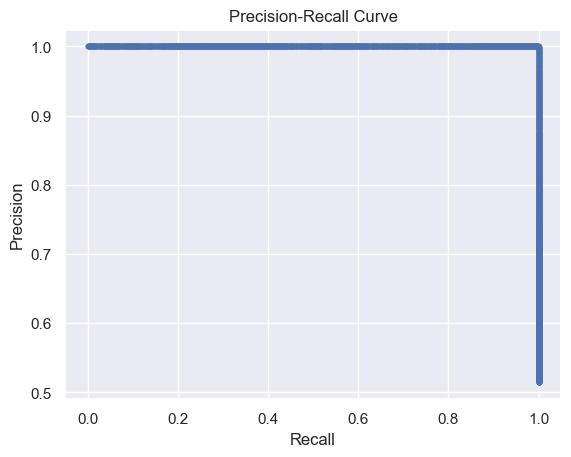

In [47]:
plot_precision_recall_curve(test_labels, predicts_1d)

In [48]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

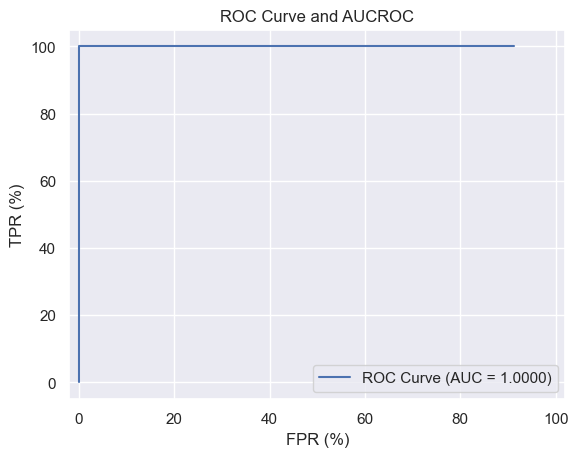

In [49]:
plot_roc_curve(test_labels, predicts_1d)

Transformando todos os valores de predições acima de 0 em 1, enquanto os outros recebem a função round(), ou seja, serão arredondados pro número inteiro mais próximo. Após isso, os números que forem iguais a 0, serão transformados em -1. É como se todo mundo igual ou menor que 0, fosse malicioso, mas 0 não é um valor malicioso de label, é mais como se fosse um threshold, então nada deve ser igual a 0. Esse problema é minimizado em classificações binárias.

In [50]:
predicts_1d = np.where(predicts_1d > 0, 1, np.round(predicts_1d))
predicts_1d = np.where(predicts_1d == 0, -1, predicts_1d)
predicts_1d

array([ 1.,  1., -1., ...,  1.,  1.,  1.], dtype=float32)

In [51]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

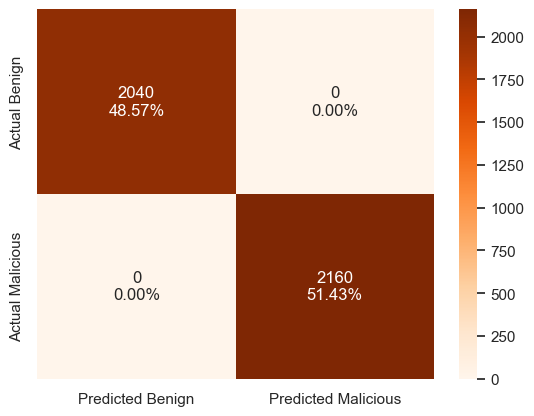

In [52]:
plot_confusion_matrix(test_labels, predicts_1d)

In [53]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [54]:
get_overall_metrics(test_labels, predicts_1d)

{'acc': 1.0, 'tpr': 1.0, 'fpr': 0.0, 'precision': 1.0, 'f1-score': 1.0}

In [55]:
del test_data, test_labels

In [56]:
#model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.keras')

In [57]:
#dump(scaler, f"models/scalers/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}")

In [58]:
del history
del loss
del predicts
del predicts_1d

## LSTM (não-supervisionado) (NÃO TERMINADO!!!)

In [59]:
s_OR_ns = "ns"
classifier_type = "bc"

In [60]:
FEATURES_COUNT = train_data_2.shape[2]

In [61]:
# Construindo o modelo Autoencoder LSTM
inputs = Input(shape=(WINDOW_SIZE, FEATURES_COUNT))
encoded = LSTM(50, activation='tanh', return_sequences=False)(inputs)  # Codificador
decoded = RepeatVector(WINDOW_SIZE)(encoded)  # Decodificador
decoded = LSTM(FEATURES_COUNT, return_sequences=True)(decoded)

# Adicionando Dropout e Normalização em Batch
decoded = Dropout(0.1)(decoded)
decoded = BatchNormalization()(decoded)

# Camada de saída
outputs = Dense(FEATURES_COUNT, kernel_regularizer=l2(0.0000001))(decoded)

# Compilando o modelo
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')

In [62]:
PATIENCE = 4

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [64]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

In [65]:
history = model.fit(train_data_2, train_data_2, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
212/212 [==============================] - 12s 47ms/step - loss: 0.1470 - val_loss: 0.1427
Epoch 2/50
212/212 [==============================] - 9s 43ms/step - loss: 0.0990 - val_loss: 0.1333
Epoch 3/50
212/212 [==============================] - 9s 43ms/step - loss: 0.0988 - val_loss: 0.1162
Epoch 4/50
212/212 [==============================] - 9s 41ms/step - loss: 0.0985 - val_loss: 0.1098
Epoch 5/50
212/212 [==============================] - 9s 43ms/step - loss: 0.0984 - val_loss: 0.1118
Epoch 6/50
212/212 [==============================] - 9s 45ms/step - loss: 0.0982 - val_loss: 0.1103
Epoch 7/50
212/212 [==============================] - 9s 44ms/step - loss: 0.0982 - val_loss: 0.1147
Epoch 8/50
212/212 [==============================] - 9s 41ms/step - loss: 0.0982 - val_loss: 0.1095
Epoch 9/50
212/212 [==============================] - 9s 43ms/step - loss: 0.0981 - val_loss: 0.1090
Epoch 10/50
212/212 [==============================] - 9s 41ms/step - loss: 0.0982 - val_l

In [66]:
predicts = model.predict(test_data_2)

786/786 [==============================] - 12s 14ms/step


In [67]:
predicts

array([[[2.29821559e-02, 6.06517434e-01, 9.09691930e-01, ...,
         3.07983786e-01, 3.02119642e-01, 3.08251947e-01],
        [2.63870042e-02, 6.02649689e-01, 9.10320163e-01, ...,
         3.05351079e-01, 3.15804482e-01, 3.09749663e-01],
        [2.77741645e-02, 6.01440072e-01, 9.10914421e-01, ...,
         3.04267138e-01, 3.22329044e-01, 3.10774386e-01],
        ...,
        [2.87136454e-02, 6.01336002e-01, 9.11996841e-01, ...,
         3.03570390e-01, 3.28138083e-01, 3.12165052e-01],
        [2.87136454e-02, 6.01336002e-01, 9.11996841e-01, ...,
         3.03570390e-01, 3.28138083e-01, 3.12165052e-01],
        [2.87136454e-02, 6.01336002e-01, 9.11996841e-01, ...,
         3.03570390e-01, 3.28138083e-01, 3.12165052e-01]],

       [[2.26068776e-02, 6.08795643e-01, 9.10269022e-01, ...,
         3.09359908e-01, 3.04114163e-01, 3.09873879e-01],
        [2.58648191e-02, 6.06169462e-01, 9.11449671e-01, ...,
         3.07426572e-01, 3.18721354e-01, 3.12206447e-01],
        [2.71960218e-02, 

In [68]:
def mean_square_error(original_data, predicted_data, threshold):
    """
    Função para classificar as amostras como benignas (1) ou malignas (-1) com base no erro de reconstrução.

    Parâmetros:
        original_data (numpy.array): Os dados originais.
        predicted_data (numpy.array): As previsões geradas pelo modelo autoencoder.
        threshold (float): O limiar de decisão para classificar as amostras.

    Retorna:
        numpy.array: Um array de classificação binária para cada amostra.
    """
    # Calcula o erro de reconstrução (MSE) para cada amostra
    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    # Classifica as amostras com base no limiar
    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    return classifications

In [69]:
def mean_absolute_error(original_data, reconstructed_data, threshold=0.5):
    
    """
    Calcula o Erro Absoluto Médio (MAE) entre os dados originais e reconstruídos.

    Args:
    - original_data: array NumPy contendo os dados originais.
    - reconstructed_data: array NumPy contendo os dados reconstruídos pelo modelo.

    Returns:
    - mae: o Erro Absoluto Médio entre os dados originais e reconstruídos.
    """


    # Calcula a diferença absoluta entre os dados originais e reconstruídos
    # Calcula o MAE como a média da diferença absoluta
    mae = np.mean((np.abs(original_data - reconstructed_data)), axis=(1, 2))

    classifications = np.where(mae < threshold, 1, -1)

    return classifications

In [70]:
def find_best_threshold_mse(original_data, predicted_data, proportion, threshold=0.5):
    
    print(threshold)

    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    if len(classifications[classifications == -1]) / len(classifications) < proportion:
        return find_best_threshold(original_data, predicted_data, proportion, 0.5*threshold)
    elif len(classifications[classifications == -1]) / len(classifications) > proportion:
        return find_best_threshold(original_data, predicted_data, proportion, 1.5*threshold)
    else:
        return threshold
    
    #if abs(anomaly_proportion - proportion) < 0.01:
    #    break

In [71]:
THRESHOLD = find_best_threshold_mse(test_data_2, predicts, malicious_proportion, 0.5)

0.5


In [72]:
classifications_mse = mean_square_error(test_data_2, predicts, THRESHOLD)

In [73]:
len(classifications_mse[classifications_mse == -1]) / len(classifications_mse)
malicious_proportion

0.6626865671641791

In [74]:
#model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.keras')

In [75]:
#THRESHOLD = str(THRESHOLD).replace(".",",")

In [76]:
#dump(scaler, f"models/scalers/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}")